# Sleep analysis
### Does sleep deprivation have an influence on programming skills?


In [ ]:
## Importing the necessary packages and the dataset
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
df = pd.read_csv("data/sleep_deprived_coding.csv")

In [ ]:
# Check out what's in the dataset
df.head()

The gpa in Italy is between 18 and 30. 

In [3]:
(df
 .groupby('sleep')
 .agg(n=('id','count'),
        mean_unit_tests=('passed_unit_tests', np.mean),
        mean_asserts=('passed_asserts', np.mean),
        mean_user_stories=('tackled_user_stories', np.mean),))

,n,mean_unit_tests,mean_asserts,mean_user_stories
sleep,,,,
deprived,15,1.133333,3.266667,1.600000
normal,21,2.904762,4.952381,2.714286


Based on this aggregation of the data it seems as though sleep deprivation influences programming skills. This conclusion makes sense. However the dataset only contains 35 observations. So the question remains whether the influence of sleep is real or due to GPA or due to chance.

Sampling is an option to further explore this question. First randomly assign sleep status to the observations at hand, then calculate the difference and repeat this for many cycles. 

In [4]:
def reshuffle(dataf):
    return (dataf
            .sample(36)
            .reset_index(drop=True)
            .assign(sleep=lambda d: np.where(d.index < 15, 'deprived', 'normal')))

def calc_diff(dataf):
    agg = (dataf
           .groupby('sleep')
           .agg(mean_unit_tests=('passed_unit_tests', np.mean),
                mean_asserts=('passed_asserts', np.mean),
                mean_user_stories=('tackled_user_stories', np.mean),)).T
    return agg['deprived'] - agg['normal']

df.pipe(reshuffle).pipe(calc_diff)


mean_unit_tests     -0.400000
mean_asserts         0.142857
mean_user_stories   -0.200000
dtype: float64

This can be used to create a histogram. This way you'll get a spread of the data if everything was left to chance.That will tell you how likely it is to be on a certain part of the histogram.

In [6]:
n = 1000
results = np.zeros((n, 3))
for i in range(n):
    results[i, :] = df.pipe(reshuffle).pipe(calc_diff)
    
results

array([[-0.28571429, -0.08571429, -0.2       ],
       [ 1.08571429,  0.25714286,  0.6       ],
       [-0.28571429,  0.48571429, -0.42857143],
       ...,
       [-0.74285714, -0.42857143, -0.31428571],
       [ 0.62857143, -0.2       ,  0.25714286],
       [-1.42857143, -0.54285714, -0.88571429]])

Turn the array into a dataframe.

In [15]:
df_diff = pd.DataFrame(results,
                      columns=['diff_unit_tests',
                              'diff_asserts',
                              'diff_user_stories'])

df_diff.head()
df_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   diff_unit_tests    1000 non-null   float64
 1   diff_asserts       1000 non-null   float64
 2   diff_user_stories  1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


These histograms show the spread in data due to chance. We can use this to check the likelihood that the original dataset is due to sleep deprivation and not chance.

The vertical lines in the histograms are the differences between sleep and no sleep in the original dataset.

In [26]:
effect_dict = dict(calc_diff(df))
effect_dict

{'mean_unit_tests': -1.7714285714285714,
 'mean_asserts': -1.685714285714286,
 'mean_user_stories': -1.1142857142857143}

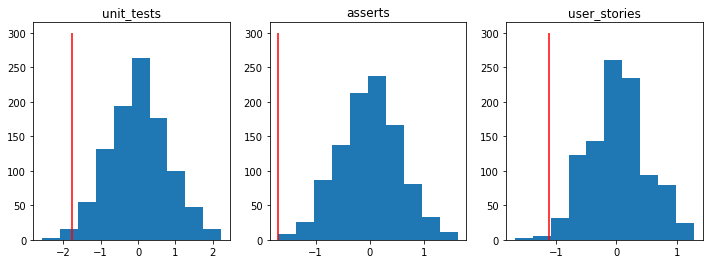

In [27]:
plt.figure(figsize=(12, 4))

for idx, name in enumerate(['unit_tests', 'asserts', 'user_stories']):
    plt.subplot(131 + idx)
    plt.hist(df_diff[f'diff_{name}'])
    plt.vlines(effect_dict[f'mean_{name}'], 0 ,300, color='red')
    plt.title(name)
    

It seems that the effect of sleep is something cannot be attributed to chance. How often is the the difference in the spread less than or equal to the difference in the original dataset?

In [29]:
effect_dict

{'mean_unit_tests': -1.7714285714285714,
 'mean_asserts': -1.685714285714286,
 'mean_user_stories': -1.1142857142857143}

In [31]:
df_diff.assign(limit=lambda d: d['diff_unit_tests'] <  -1.7714)['limit'].mean()

0.009

In [32]:
df_diff.assign(limit=lambda d: d['diff_asserts'] <  -1.6857)['limit'].mean()

0.002

In [33]:
df_diff.assign(limit=lambda d: d['diff_user_stories'] < -1.1142)['limit'].mean()

0.008

These differences are quite unlikely in the chance spread. So it is quite convincing that the diffence between sleep and no sleep is real and not due to chance.

### The question remains whether this diffence is due to the gpa and not sleep.
So let's take a look at those numbers.

In [45]:
# Make gpa a categorical variable by splitting into above and below the mean.

agg = (df
       .assign(gpa=lambda d: d['gpa'] < d['gpa'].mean())
       .groupby('gpa')
       .agg(mean_unit_tests=('passed_unit_tests', np.mean),
            mean_asserts=('passed_asserts', np.mean),
            mean_user_stories=('tackled_user_stories', np.mean))).T

agg[False] - agg[True]

# put the difference in gpa in dictionary

effect_dict = dict(agg[False] - agg[True])
effect_dict


{'mean_unit_tests': 0.19480519480519476,
 'mean_asserts': 0.29220779220779214,
 'mean_user_stories': 0.05844155844155852}

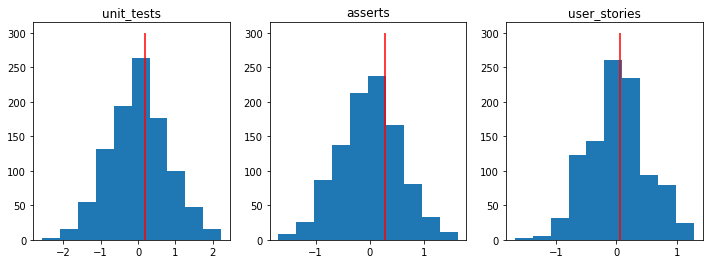

In [46]:
plt.figure(figsize=(12, 4))

for idx, name in enumerate(['unit_tests', 'asserts', 'user_stories']):
    plt.subplot(131 + idx)
    plt.hist(df_diff[f'diff_{name}'])
    plt.vlines(effect_dict[f'mean_{name}'], 0 ,300, color='red')
    plt.title(name)

In [48]:
df_diff.assign(limit=lambda d: d['diff_unit_tests'] <  0.1948)['limit'].mean()

0.619

In [49]:
df_diff.assign(limit=lambda d: d['diff_unit_tests'] <  0.2922)['limit'].mean()

0.662

In [50]:
df_diff.assign(limit=lambda d: d['diff_unit_tests'] <  0.05844)['limit'].mean()

0.571

It seems unlikely that these differences are due to gpa and quite likely that is it due to chance.

__Statistically sleep has more of an effect on programming abilities than GPA.__